<h1> Checkpoint Zero </h1>

Welcome! 

For now: read the README at https://github.com/thomasomota/Nordnet-Investment-Helper

In [1]:
#IMPORTS 

import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

In [2]:
# CONSTANTS

URL_FOND = "https://www.nordnet.no/mux/web/fonder/sok.html?nn_kategori=&kategori=&forvaltare=&sokord=&sok=1&ppm=0&nobuy=&flik=&nm=&typ=1"

In [3]:
fund_overview_response = requests.get(URL_FOND)

We now have a HTML response thanks to the wonderful requests lib. To get the HTML content of the request object, we look at the `.text` attribute of the response. 

In [4]:
fund_overview_response.text[:1000:]

'<!DOCTYPE html>\n<html lang="no">\n\n\n<head>\n\t<meta http-equiv="content-language" content="no" />\n  \t<meta property="og:image:secure_url" content="https://www.nordnet.se/webdav/files/image/nordnet-ogp.jpg" />\n\t<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1" />\n\t<meta name="google" content="notranslate" />\n  \t<meta http-equiv="X-UA-Compatible" content="IE=edge" />\n\n\t<!-- app-install banners metadata -->\n\t<meta name="apple-itunes-app" content="app-id=345038631" />\n\t<meta name="google-play-app" content="app-id=com.nordnet">\n\t<meta name="msApplication-ID" content="f5e7e9c5-3ff2-491d-bba0-877921c82ff7"/>\n\t<meta name="msApplication-PackageFamilyName" content="NordnetBankAB.NordnetBank_rjgcxy7drxffr"/>\n\n\n\t\t<meta name="Author" content="Nordnet Bank" />\r\n<meta name="keywords" content="nordnet norge" />\r\n<meta name="description" content="Kjøp og selg verdipapirer i hele verden. Svært lav kurtasje og ingen faste avgifter. Opprett konto i dag

Woah.. That's ugly! But fear not, we have beautifulSoup! 


In [5]:
soup = BeautifulSoup(fund_overview_response.text, 'lxml')

# To show content of a variable, just write the variable in the end of the Cell! It's really long so commented out
# soup

This looks way better, now we can start interpreting the HTML!

All we really need is every href that goes to the view page for a specific fund. First thing we'll do is to find all href-strings in the HTML. 

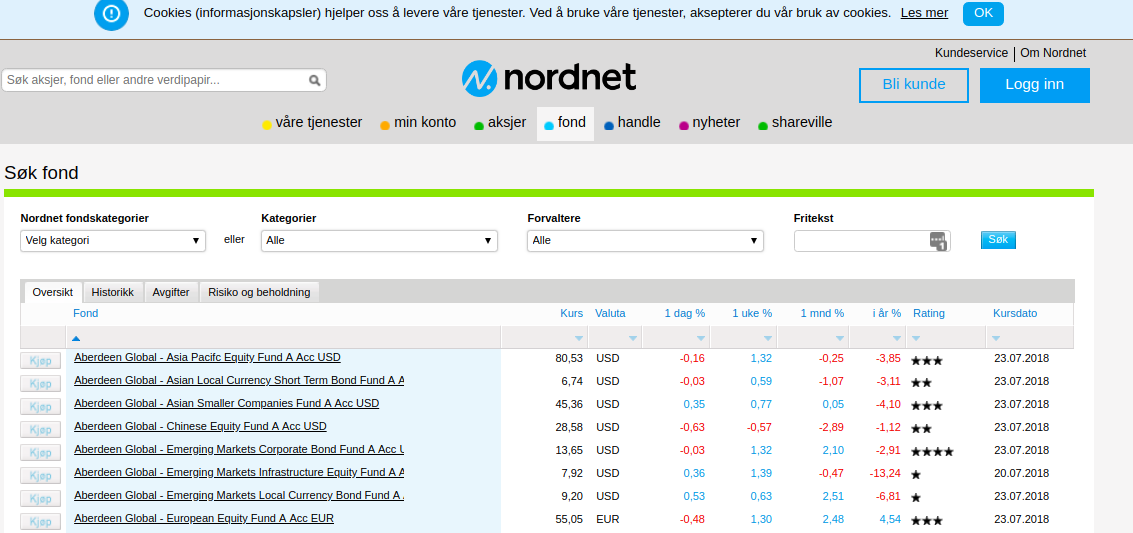


In [6]:
soup.find_all('a', href=True)[:10]

[<a href="/mux/web/info/cookies.html?cmpi=start-cookies">Les mer</a>,
 <a href="/kundeservice/start.html?cmpi=customer-service-NO">Kundeservice</a>,
 <a class="last" href="http://nordnetab.com/about/about-nordnet" target="_blank">Om Nordnet</a>,
 <a class="btn-secondary signup-btn" href="/mux/login/start.html?cmpi=start-loggain&amp;state=signup" rel="nofollow">
 				  Bli kunde
                                 </a>,
 <a class="btn-primary signin-btn" href="/mux/login/start.html?cmpi=start-loggain&amp;state=signin" rel="nofollow">
 				  Logg inn
                                 </a>,
 <a class="logo--new" href="/mux/web/nordnet/index.html">
 <img alt="Nordnet" height="33" src="/now/images/logo--new2x.png" width="158"/>
 </a>,
 <a accesskey="1" href="#" onclick="mainMenu.toggle('nordnet', event); return false"><span>våre tjenester</span></a>,
 <a accesskey="2" href="#" onclick="mainMenu.toggle('depa', event); return false"><span>min konto</span></a>,
 <a accesskey="3" href="#" onclick="

We see that there's a lot of unrelevant links ( or hrefs ), so we have to limit our search. 

Note that every link to a specific fund page begins with `/mux/web/fonder/fondfakta.html?`. Let's use this to limit our results. 

In [7]:
regex_string = "/mux/web/fonder/fondfakta.html?"

a_tags_with_correct_href = soup.find_all('a', attrs={'href': re.compile(regex_string)})

len(a_tags_with_correct_href)

694

694 Funds, that seems a lot, but we'll accept that as good enough for now! If we see we have wrong links further down the process we'll do go back and fix it

Notice that the url's we got out doesn't have the right prefix `https://www.nordnet.no`. Let's fix that

In [8]:
nordnet_prefix = "https://www.nordnet.no"
links = []

for tag in a_tags_with_correct_href: 
    href = nordnet_prefix + tag.get('href')
    links.append(href)

We now got all the links we need from the first page. Done deal! let's work with the first link for now, to see if we can get the information we need to get proof of concept. 

In [9]:
html_link = links[0] 

In [10]:
fund_detail_page_response = requests.get(html_link).text
soup = BeautifulSoup(fund_detail_page_response, 'lxml')

print(soup)

#soup

<!DOCTYPE html>
<html lang="no">
<head>
<meta content="no" http-equiv="content-language"/>
<meta content="https://www.nordnet.se/webdav/files/image/nordnet-ogp.jpg" property="og:image:secure_url"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="notranslate" name="google"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<!-- app-install banners metadata -->
<meta content="app-id=345038631" name="apple-itunes-app"/>
<meta content="app-id=com.nordnet" name="google-play-app"/>
<meta content="f5e7e9c5-3ff2-491d-bba0-877921c82ff7" name="msApplication-ID"/>
<meta content="NordnetBankAB.NordnetBank_rjgcxy7drxffr" name="msApplication-PackageFamilyName"/>
<meta content="Nordnet Bank" name="author"/>
<meta content="Nordnet Norge, fond." name="keywords"/>
<meta content="Aktuell og nyttig informasjon om Aberdeen Global - Asia Pacifc Equity Fund A Acc USD." name="description"/>
<title>Aberdeen Global - Asia Pacifc Equity Fund A Acc USD - Fond - Nordnet</t

We now have a slightly harder problem to solve, as some of the data we need is hidden by a navigation tab on the detail page. In fact they're "hidden" under an `<iframe/>` tag which we'll extract. 

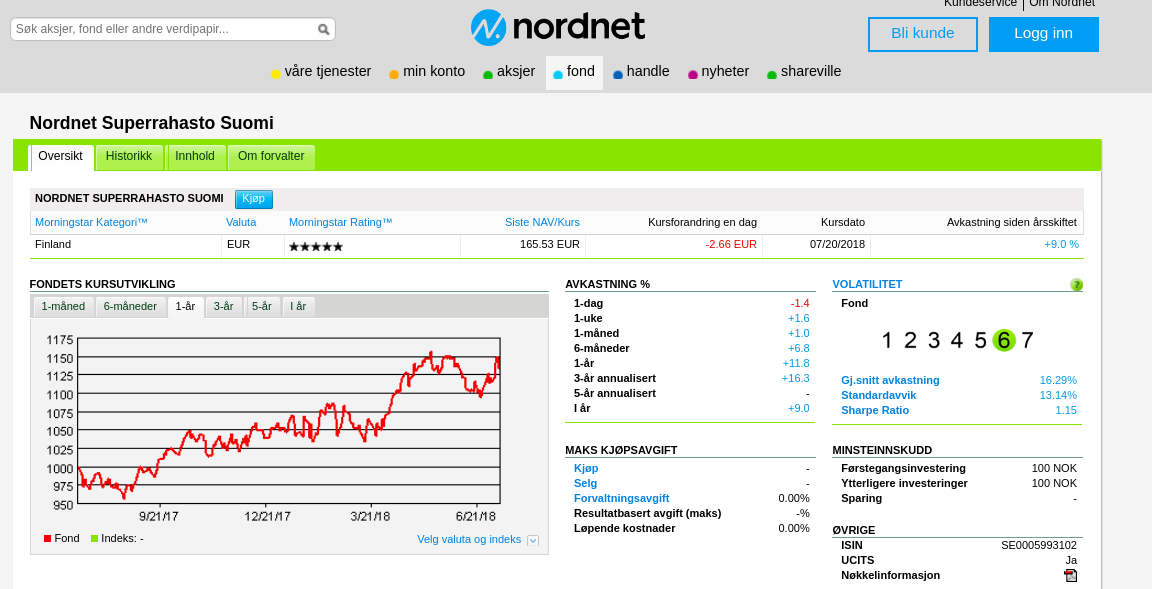

We need the data in the tab "Innhold"! 

As we click on the navigation-tabs, we see that the URL of the browser doesn't change, i.e the information displayed in the "Innhold"-tab should be available in the HTML if we're lucky. 

Using the inspection-tool in the browser we find that the information in the "Innhold"-tab is refrenced with an URL! 

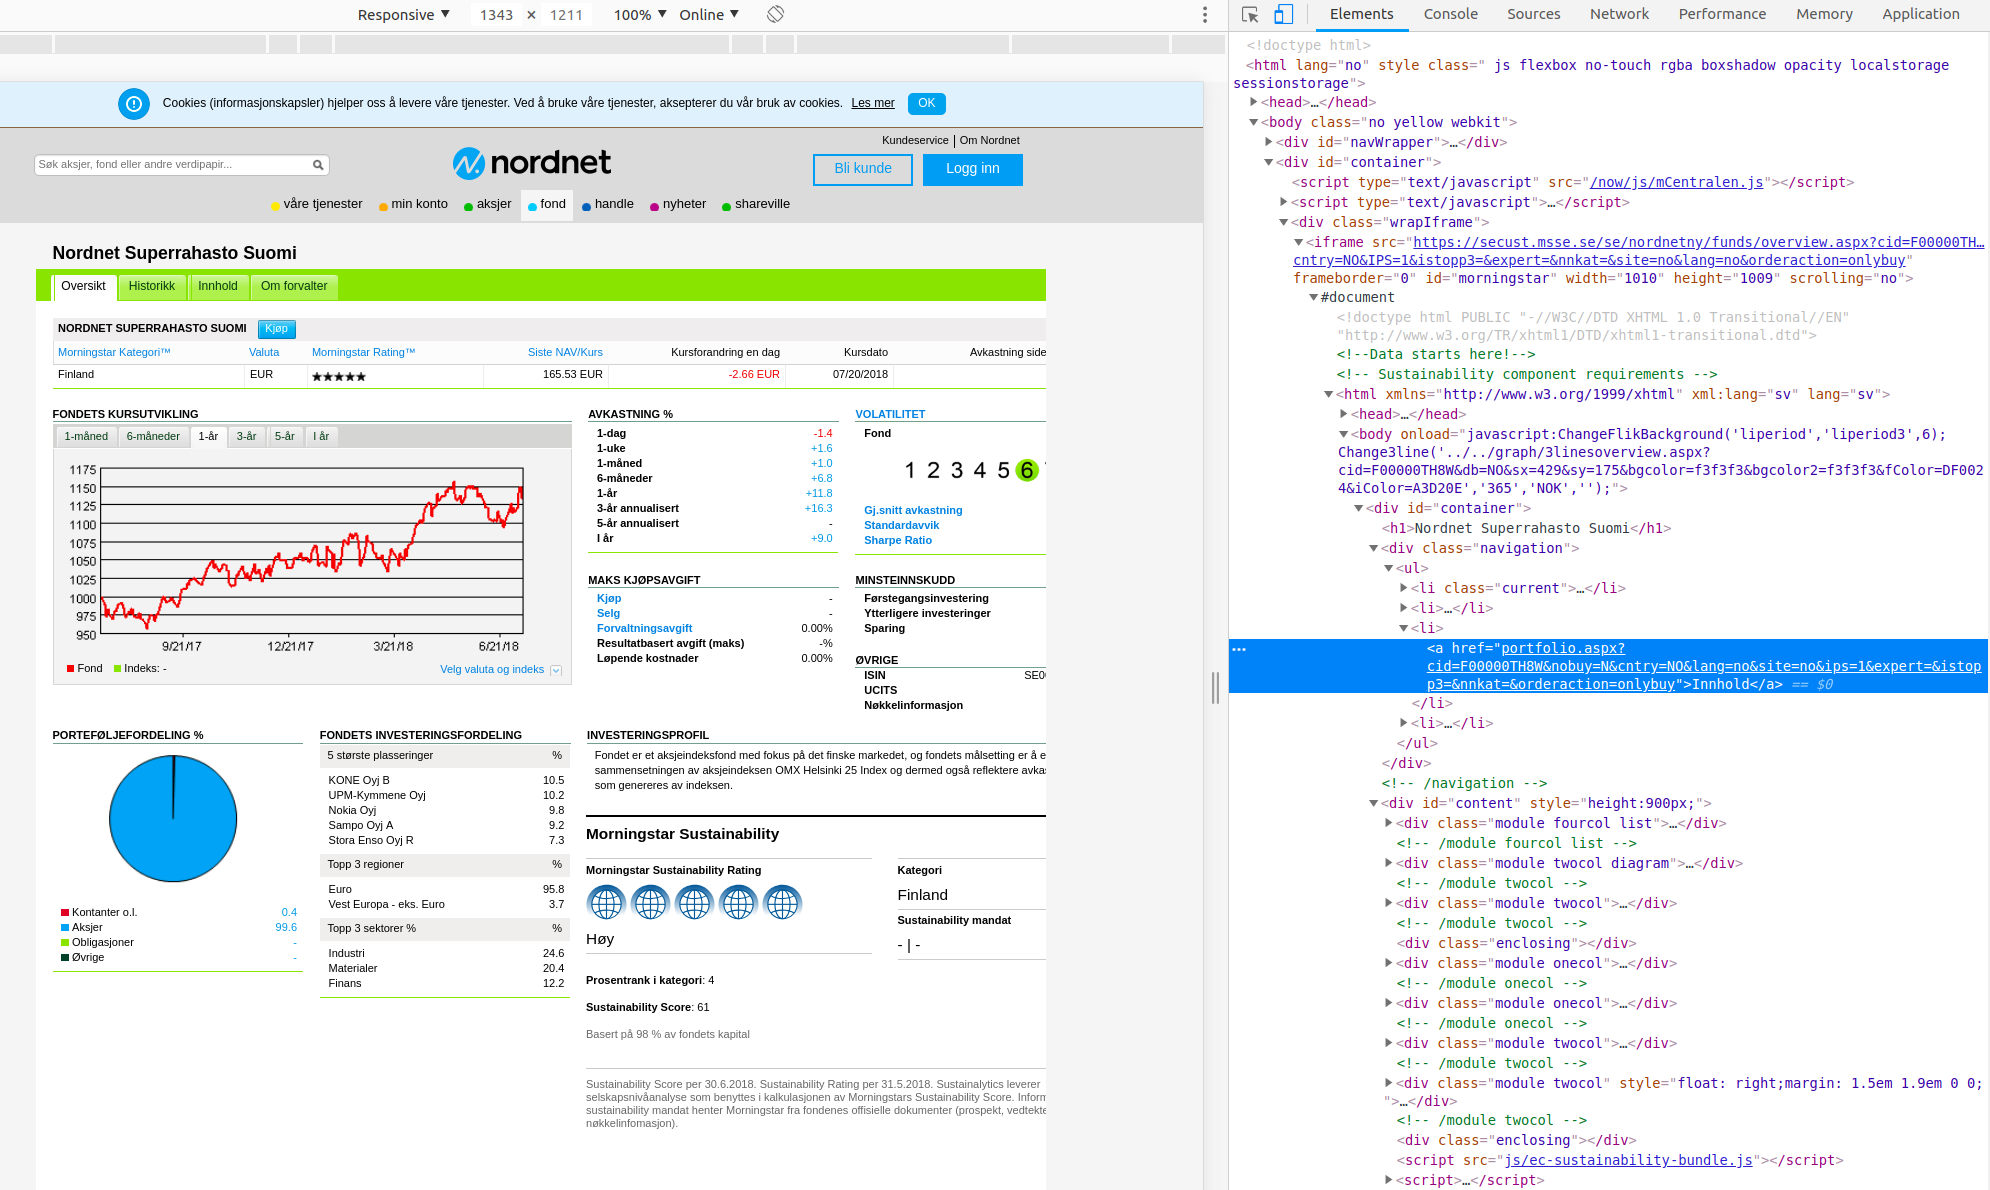

We already know how to extract theese with BeautifulSoup, so let's do that! 

In [11]:
iframe_element = soup.find(lambda tag: tag.name == "iframe")

In [12]:
overview_url = iframe_element.get('src')
portifolio_url = "https://secust.msse.se/se/nordnetny/funds/portfolio" + overview_url.split("overview")[1]

overview_soup = BeautifulSoup(requests.get(overview_url).text, 'lxml')
portifolio_soup = BeautifulSoup(requests.get(portifolio_url).text, 'lxml')

<h3> Checkpoint Alfa </h3>

Okay, so now we got two soups, one for each of the tabs we need! 

Next, we'll go through theese two soups to try to fetch out the data we're interested in! 

The plan is to put all of this information, for every fund available, into a Pandas dataframe. From there it will be a lot easier to handle and serve the date to the next step of this project.  



In [13]:
cost_table_soup = overview_soup.find("h2", text = "Maks kjøpsavgift").next_sibling.next_sibling

# This gives us the table we want to look at first, the costs of investing in the fund 

row_names = ["Kjøp", "Selg", "Forvaltningsavgift", "Resultatbasert avgift(maks)", "Løpende kostnader"]
td_tags = cost_table_soup.findAll("td", class_=None)

#Regex to find the values in the td_tags, or insert '-' if no value
values = [re.findall("\d+\.\d+", text.text)[0] if re.findall("\d+\.\d+", text.text) else '0'  for text in td_tags]

columns = ['Kjøpsavgift', "Salgsavgift", "Forvaltningsavgift", "Resultatbastert avgift(maks)", "Løpende kostnader"]

# Creating the dictionary in which our data lies, which will be used to initiate the dataframe
data = {}
for x in range(0, len(columns)):
    name = columns[x]
    value = values[x]
    data[name] = value

#Creating the dataFrame, setting an numeric index. 
dataFrame_costs = pd.DataFrame(data, columns= columns, index=[0])

dataFrame_costs

,Kjøpsavgift,Salgsavgift,Forvaltningsavgift,Resultatbastert avgift(maks),Løpende kostnader
0,0,0,1.75,0,2.00


We got ourselves a dataframe with the available information regarding costs for this fund!

You might not have flinched, but notice that we're setting the missing values to 0. This is because Nordnet uses '-' as a placeholder for when the cost is zero! If they were missing values, this assumption could lead to misinformation and faulty analytics.

The second piece of information we want from this page is the `standard deviation` and the `Sharpe Ratio`. Let's get that information and process it in the same way as for the costs. 


In [14]:
volatility_table = overview_soup.find("a", text = "Gj.snitt avkastning").parent.parent.parent

row_names = ["Gj.snitt avkastning", "Standardavvik", "Sharpe Ratio"]
td_tags = volatility_table.findAll("td", class_=None)

#Regex to find the values in the td_tags, or insert '-' if no value
values = [re.findall("\d+\.\d+", text.text)[0] if re.findall("\d+\.\d+", text.text) else '0'  for text in td_tags]

columns = ["Gj.snitt avkastning", "Standardavvik", "Sharpe Ratio"]

# Creating the dictionary in which our data lies, which will be used to initiate the dataframe
data = {}
for x in range(0, len(columns)):
    name = columns[x]
    value = values[x]
    data[name] = value

#Creating the dataFrame, setting an numeric index. 
dataFrame_volatility = pd.DataFrame(data, columns= columns, index=[0])

dataFrame_volatility

,Gj.snitt avkastning,Standardavvik,Sharpe Ratio
0,5.21,12.78,0.36


There we go, another dataFrame containing the volatility information on the fund! 

The next step is to combine the two dataFrames, and put the name of the fund as a column

In [15]:
dataframe_fund = pd.concat([dataFrame_costs, dataFrame_volatility], axis=1)

fund_name = overview_soup.find("div", id="container").h1.text

dataframe_fund['Name'] = fund_name

dataframe_fund

,Kjøpsavgift,Salgsavgift,Forvaltningsavgift,Resultatbastert avgift(maks),Løpende kostnader,Gj.snitt avkastning,Standardavvik,Sharpe Ratio,Name
0,0,0,1.75,0,2.00,5.21,12.78,0.36,Aberdeen Global - Asia Pacifc Equity Fund A Ac...


<h2> Checkpoint Bravo </h2>

We now how a more or less complete dataframe for one fund! Later we'll add more data, but for now let's look at cleaning up our project by putting functionality in functions, in order to make our code cleaner! 

From here on we go to our next Jupyter Notebook file: `Creating the complete dataframe`